In [1]:
!pip install librosa

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Loading an audio file:

In [3]:
import librosa
audio_data = '../input/rfcx-species-audio-detection/train/00204008d.flac'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(1323000,) 22050


#### This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono. We can change this behavior by resampling at 44.1KHz.

In [4]:
librosa.load(audio_data, sr=44100)

(array([0.00776862, 0.00637632, 0.00754364, ..., 0.00486779, 0.00244802,
        0.00076159], dtype=float32),
 44100)

### Playing Audio:

#### Using,IPython.display.Audio you can play the audio in your jupyter notebook.

In [5]:
import IPython.display as ipd
ipd.Audio(audio_data)

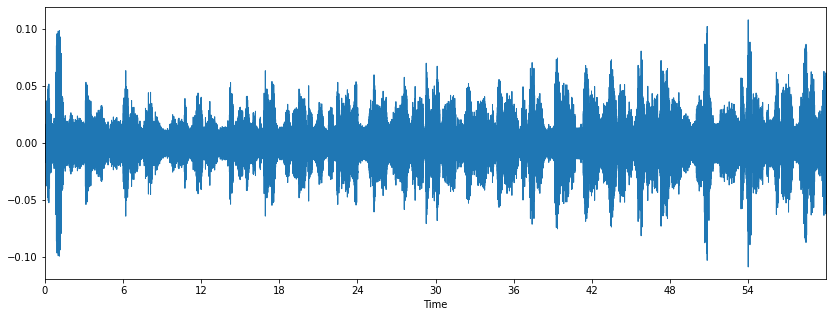

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

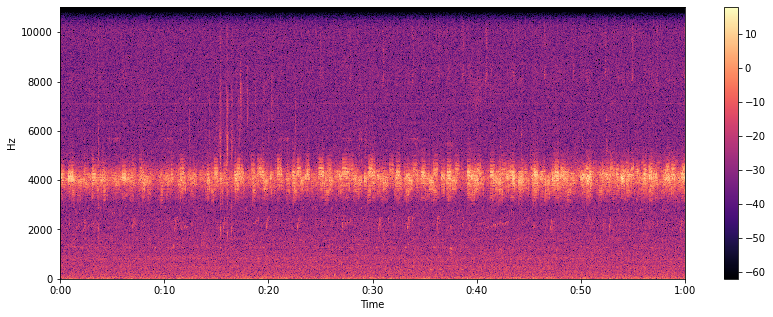

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### .stft() converts data into short term Fourier transform. [STFT](https://www.youtube.com/watch?v=g1_wcbGUcDY) converts signals such that we can know the amplitude of the given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal. .specshow is used to display a spectrogram.

#### The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

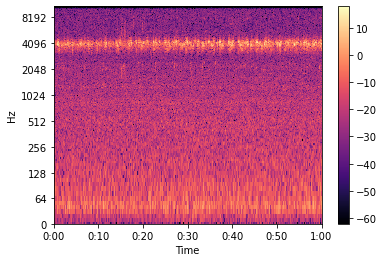

In [8]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

# Create an Audio Signal:

In [9]:
# In new Librosa version, you need to use soundfile
import soundfile as sf

In [10]:
sr = 22050 # sample rate
T = 5.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*220*t)# pure sine wave at 220 Hz
#Playing the audio
ipd.Audio(x, rate=sr) # load a NumPy array
#Saving the audio
sf.write('tone_220.wav', x, sr)

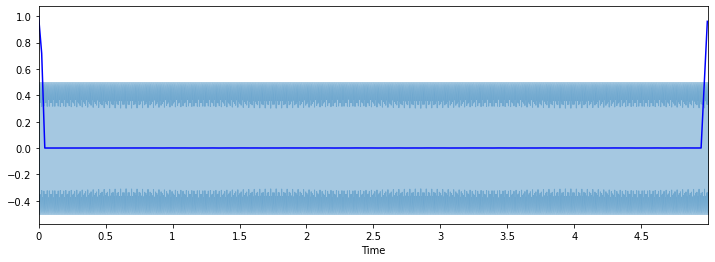

In [11]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

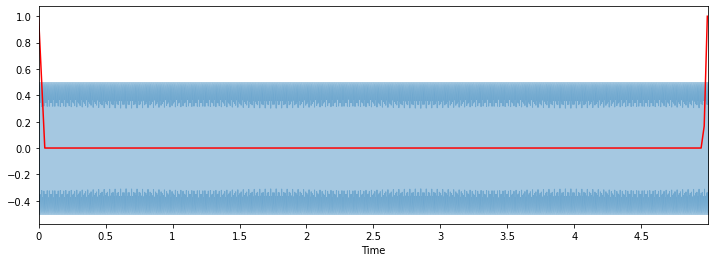

In [12]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

# Spectral Bandwidth

#### The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

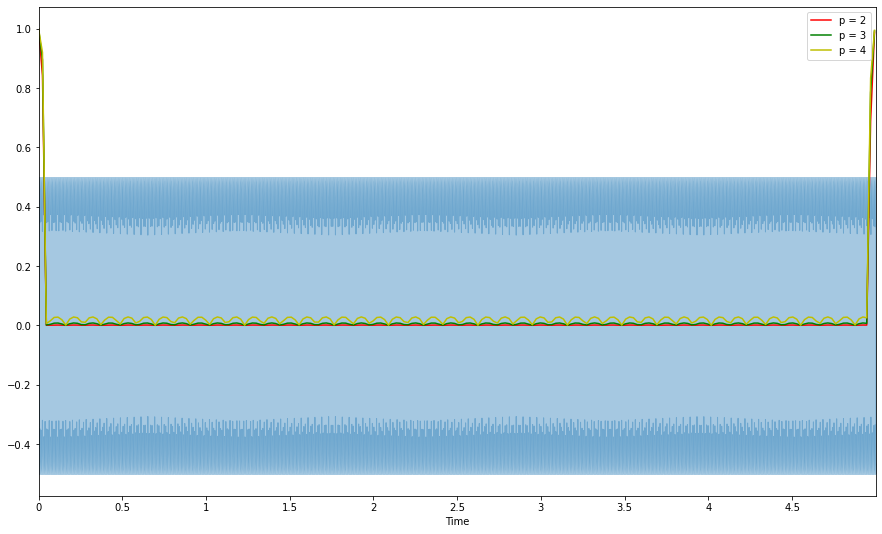

In [13]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

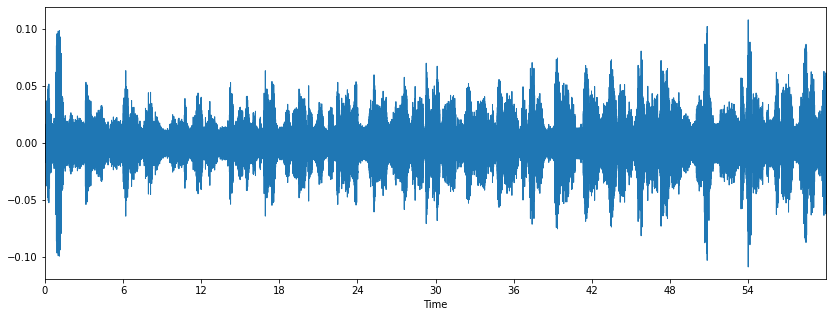

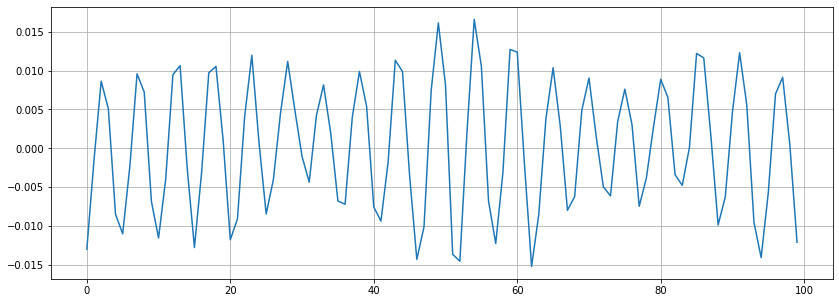

In [14]:
x, sr = librosa.load(audio_data)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

## How many zero crossings?

In [15]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

38


# Mel-Frequency Cepstral Coefficients(MFCCs)

(20, 2584)


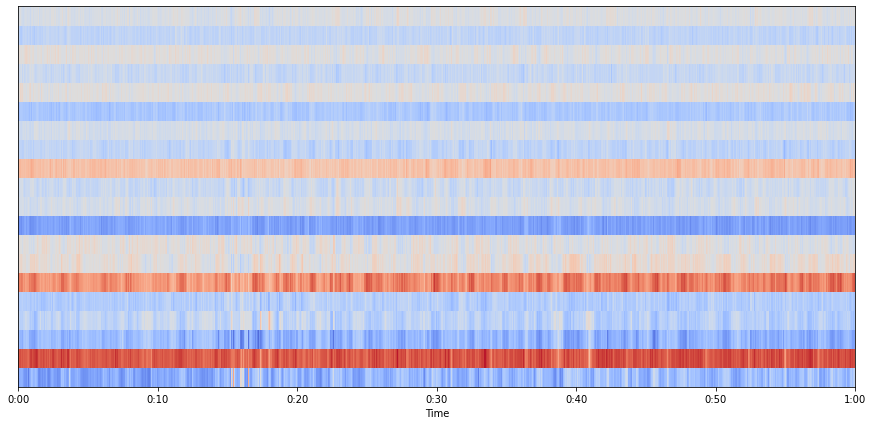

In [16]:
fs=10
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# Chroma feature

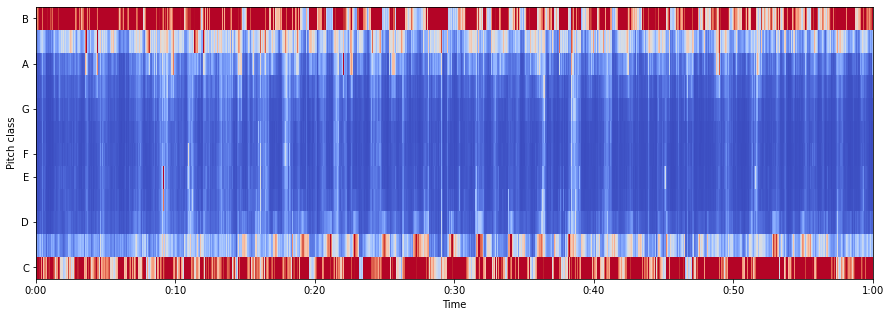

In [17]:
hop_length=12
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

In [18]:
!pip install  resnest > /dev/null

In [19]:
from pathlib import Path
import librosa as lb

import torch
from  torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

from resnest.torch import resnest50

In [20]:
NUM_CLASSES = 24
SR = 16_000
DURATION =  60
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")

In [21]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [22]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return np.moveaxis(image, 2, 0).astype(np.float32)


def crop_or_pad(y, length, sr, is_train=True):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    elif len(y) > length:
        if not is_train:
            start = 0
        else:
            start = np.random.randint(len(y) - length)

        y = y[start:start + length]

    y = y.astype(np.float32, copy=False)

    return y

In [23]:
class RFCXDataset(Dataset):

    def __init__(self, data, sr, n_mels=128, fmin=0, fmax=None,  is_train=False,
                 num_classes=NUM_CLASSES, root=None, duration=DURATION):

        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.is_train = is_train

        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
        
        self.root =  root or (TRAIN_AUDIO_ROOT if self.is_train else TEST_AUDIO_ROOT)

        self.wav_transfos = get_wav_transforms() if self.is_train else None

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax)


    def __len__(self):
        return len(self.data)
    
    def read_index(self, idx, fill_val=1.0, offset=None, use_offset=True):
        d = self.data.iloc[idx]
        record, species = d["recording_id"], d["species_id"]
        try:
            if use_offset and (self.duration < d["duration"]+1):
                offset = offset or np.random.uniform(1, int(d["duration"]-self.duration))

            y, _ = lb.load(self.root.joinpath(record).with_suffix(".flac").as_posix(),
                           sr=self.sr, duration=self.duration, offset=offset)
            
            if self.wav_transfos is not None:
                y = self.wav_transfos(y, self.sr)
            y = crop_or_pad(y, self.audio_length, sr=self.sr)
            t = np.zeros(self.num_classes)
            t[species] = fill_val
        except Exception as e:
#             print(e)
            raise ValueError()  from  e
            y = np.zeros(self.audio_length)
            t = np.zeros(self.num_classes)
        
        return y,t
            
        

    def __getitem__(self, idx):

        y, t = self.read_index(idx)
        
        
        melspec = self.mel_spec_computer(y) 
        image = mono_to_color(melspec)
        image = normalize(image, mean=None, std=None)

        return image, t

In [24]:
def get_duration(audio_name, root=TEST_AUDIO_ROOT):
    return lb.get_duration(filename=root.joinpath(audio_name).with_suffix(".flac"))

In [25]:
data = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})
data["species_id"] = [[] for _ in range(len(data))]

print(data.shape)
data["duration"] = data["recording_id"].apply(get_duration)

(1992, 2)


# Inference

In [26]:
TEST_BATCH_SIZE = 40
TEST_NUM_WORKERS = 2

In [27]:
test_data = RFCXDataset(data=data, sr=SR)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, num_workers=TEST_NUM_WORKERS)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = resnest50(pretrained=True).to(device)
n_features = net.fc.in_features
net.fc = torch.nn.Linear(n_features, NUM_CLASSES)
net = net.to(device)
net.load_state_dict(torch.load("../input/kkiller-rfcx-species-detection-public-checkpoints/rfcx_resnest50.pth", map_location=device))
net = net.eval()
net

Downloading: "https://s3.us-west-1.wasabisys.com/resnest/torch/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
        (conv): Conv2d

In [29]:
preds = []
net.eval()
with torch.no_grad():
    for (xb, yb) in  tqdm(test_loader):
        xb, yb = xb.to(device), yb.to(device)
        o = net(xb)
        o = torch.sigmoid(o) 
        preds.append(o.detach().cpu().numpy())
preds = np.vstack(preds)
preds.shape

(1992, 24)

In [30]:
sub = pd.DataFrame(preds, columns=[f"s{i}" for i in range(24)])
sub["recording_id"] = data["recording_id"].values[:len(sub)]
sub = sub[["recording_id"] + [f"s{i}" for i in range(24)]]
print(sub.shape)
sub.head()

(1992, 25)


recording_id        s0        s1        s2        s3        s4        s5  \
0    e172b879e  0.543626  0.001276  0.004536  0.033128  0.000055  0.038948   
1    6a69edc38  0.002506  0.002248  0.000449  0.003221  0.000494  0.000422   
2    a5bb1b9a4  0.077532  0.006784  0.002256  0.002438  0.132001  0.035228   
3    ca3845296  0.001359  0.001192  0.001755  0.001028  0.008571  0.143190   
4    88f845482  0.003671  0.000920  0.000785  0.002232  0.002160  0.001150   

         s6        s7        s8  ...       s14       s15       s16       s17  \
0  0.014061  0.024059  0.000162  ...  0.000652  0.038043  0.001591  0.025357   
1  0.004996  0.615400  0.001017  ...  0.002040  0.419215  0.009505  0.002322   
2  0.003978  0.008825  0.052550  ...  0.005844  0.000773  0.003614  0.003374   
3  0.014045  0.003173  0.000732  ...  0.002476  0.005128  0.000798  0.002640   
4  0.028305  0.013537  0.001554  ...  0.494236  0.067261  0.004203  0.007504   

        s18       s19       s20       s21       s22       s23  
0  0.000165  0.011205  0.031096  0.000178  0.009241  0.024911  
1  0.000414  0.002433  0.009381  0.002207  0.008085  0.001588  
2  0.263103  0.004272  0.006499  0.013434  0.001250  0.002015  
3  0.060201  0.158923  0.019780  0.000256  0.011795  0.102056  
4  0.001818  0.002466  0.007742  0.002819  0.002397  0.085478  

[5 rows x 25 columns]

In [31]:
sub.to_csv("submission.csv", index=False)